# UMD FIRE Stream- Genome Computing VI
## Genome Computing-specific data & Distributions
### Introduction to `seaborn`

Here we will fine-tune tool usage for Genome Computing specific tasks and introduce methods from the `seaborn` and `sklearn` modules.

In this notebook we will learn:
<ul>
    <li>parse and organize data</li>
    <li>figure data best practices</li>
    <li>making distribution plots with `seaborn`</li>
</ul>

## Genome Computing: Parameter File Construction
### From sequence and standard rest state

Parameter files are critical in our structural work. Rather than build 3D structures using all-atom .pdb files, we can make approximations about the kind of DNA to model after, such as the biologically-dominant B-DNA form. This means that the base pairs can be approximated as regular rectangular planes.

Thus, to make a 100-bp chain of DNA, rather than making a file of ~ 100-bp*(2 chains)*(30 atoms)*(3 Cartesian coordinates), all we need are the rigid-body base-pair step parameters, which is 100-bp*(6 parameters). A much smaller file.

Analysis of experimental findings has given us a sense of sequence specific effects. Here we will make a 125-bp structure of a random DNA sequence using one such sequence-specific data (see: Olson, et al, PNAS 1998).

In [2]:
# First, import packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Next, set up any variables, lists, and dictionaries that may be used through this section.
# Pre-loading such items at the beginning of code is a great practice, especially if a goal would be to turn a notebook into a python script

bases     = ['A','T','C','G']
basepairs = {'A':'A-T', 'T':'T-A', 'C':'C-G', 'G':'G-C'}


# Check to see if list and dictionary works. Remove the comment-out symbols below and execute codeblock
N_seq = 125
seq   = ''.join(np.random.choice(bases) for i in range(N_seq))
print(seq)
for i in range(len(seq)):
    print(basepairs[ seq[i] ])


AGGTCGATCTGTACACCTGTTACCCAAAGGGCTATTGTGCATCGTAGCACCTTGACAATAAGATGACGTGACAAAGCAGGATCTCGGTCCCTTGTCGCGGCCATCGGAAAGTTGGAAACGGGACC
A-T
G-C
G-C
T-A
C-G
G-C
A-T
T-A
C-G
T-A
G-C
T-A
A-T
C-G
A-T
C-G
C-G
T-A
G-C
T-A
T-A
A-T
C-G
C-G
C-G
A-T
A-T
A-T
G-C
G-C
G-C
C-G
T-A
A-T
T-A
T-A
G-C
T-A
G-C
C-G
A-T
T-A
C-G
G-C
T-A
A-T
G-C
C-G
A-T
C-G
C-G
T-A
T-A
G-C
A-T
C-G
A-T
A-T
T-A
A-T
A-T
G-C
A-T
T-A
G-C
A-T
C-G
G-C
T-A
G-C
A-T
C-G
A-T
A-T
A-T
G-C
C-G
A-T
G-C
G-C
A-T
T-A
C-G
T-A
C-G
G-C
G-C
T-A
C-G
C-G
C-G
T-A
T-A
G-C
T-A
C-G
G-C
C-G
G-C
G-C
C-G
C-G
A-T
T-A
C-G
G-C
G-C
A-T
A-T
A-T
G-C
T-A
T-A
G-C
G-C
A-T
A-T
A-T
C-G
G-C
G-C
G-C
A-T
C-G
C-G


In [4]:
# The pre-loading portion should include your standard rest-state model.
# This is a formatted text file, so we should reorganize our data to be easier in interact with

# I have commented out several "read_csv" keyboards that will add in our reorganization
# --- remove each comment to get a better sense of what they do
# --- or visit the read_csv() documentation here: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

stds = pd.read_csv("datafiles/stepparameters_olson1998.txt", 
                   names=['dimer','tilt','roll','twist','shift','slide','rise'],
                   engine="python",
                   index_col="dimer", 
                   delimiter=',|={',  
                  )

# -!- Fix the rise column
stds.rise = stds.rise.str.replace('}','', regex=True).astype(float)
stds

,tilt,roll,twist,shift,slide,rise
dimer,,,,,,
AA,-1.4,0.7,35.1,-0.03,-0.08,3.27
AC,-0.1,0.7,31.5,0.13,-0.58,3.36
AG,-1.7,4.5,31.9,0.09,-0.25,3.34
AT,0.0,1.1,29.3,0.00,-0.59,3.31
CA,0.5,4.7,37.3,0.09,0.53,3.33
CC,0.1,3.6,32.9,-0.05,-0.22,3.42
CG,0.0,5.4,36.1,0.00,0.41,3.39
CT,1.5,1.9,36.3,0.28,0.09,3.37
GA,-1.5,1.9,36.3,-0.28,0.09,3.37


The data in this file is organized by <b>dimer sequence</b>.

Rather than the 4 base pairs (A, G, T, C), there are 4<sup>2</sup> or 16 base-pair steps.
This gives us a lot of information to work with, study, and generate models around.

We need to make a new dataframe and populate with data from our rest state based on our random DNA sequence above.

The key will be programmatically getting the dimer we want from the string, accessing our rest state, and copying that data to our dataframe

In [5]:
# Make an empty dataframe with a length that matches the length of the DNA sequence
# Make sure you use the same base-pair step parameter headers as the one from the rest state file

maindf = pd.DataFrame(columns=['#'] + stds.columns.values.tolist(),
                      index=[i for i in range(len(seq))])


In [6]:
# Next we will use a series of for and if loops to populate the dataframe from the rest state

# --- FILL IN THE  "<___>" MISSING CODE

for i in range(len(seq)):
    # Insert the base pair 
    maindf.at[i, '#'] = basepairs[ seq[i] ]
    
    # loop over the six parameters from the rest state file
    for PAR in ['tilt','roll','twist','shift','slide','rise']: 
        # Recall that since these are base-pair STEP parameters, these must be zero in the first row
        if i == 0:
            maindf.at[i, PAR] = 0.000
        
        # Add the DIMER value from the rest state into this line
        else:
            maindf.at[i, PAR] = stds.at[ seq[i-1]+seq[i] , PAR]


In [7]:
# Check the dataframe by viewing the top 10 rows

maindf.head(10)

,#,tilt,roll,twist,shift,slide,rise
0,A-T,0.0,0.0,0.0,0.0,0.0,0.0
1,G-C,-1.7,4.5,31.9,0.09,-0.25,3.34
2,G-C,-0.1,3.6,32.9,0.05,-0.22,3.42
3,T-A,-0.5,4.7,37.3,-0.09,0.53,3.33
4,C-G,1.7,4.5,31.9,-0.09,-0.25,3.34
5,G-C,0.0,5.4,36.1,0.0,0.41,3.39
6,A-T,-1.5,1.9,36.3,-0.28,0.09,3.37
7,T-A,0.0,1.1,29.3,0.0,-0.59,3.31
8,C-G,1.7,4.5,31.9,-0.09,-0.25,3.34
9,T-A,1.5,1.9,36.3,0.28,0.09,3.37


In [8]:
# Using the DataFrame.to_csv() function, save this as a .par file

maindf.to_csv("nb06_random-n125_olson1998.par")


In [9]:
# -!- STOP
# Open the file you just made. Something is off here. 
# we don't want the values on the left.
# We can use booleans with the index keyword to get rid of them

maindf.to_csv("nb06_random-n125_olson1998.par", index=False)

In [10]:
# Task:
# Using the same rest state, make a .par text file of parameters for the Zechiedrich 336-bp sequence below:
# AAACGCGCGAGGCAGCTGTATGGCATGAAAGAGTTCTTCCCGGAAAACGCGGTGGAATATTTCGTTTCCTACTACGACTACTATCAGCCGGAAGCCTATGTACCGAGTTCCGACACTTTCATTGAGAAAGATGCCTCAGCTCTGTTACAGGTCACTAATACCATCTAAGTAGTTGATTCATAGTGACTGCATATGTTGTGTTTTACAGTATTATGTAGTCTGTTTTTTATGCAAAATCTAATTTAATATATTGATATTTATATCATTTTACGTTTCTCGTTCAGCTTTTTTATACTAACTTGAGCGAAACGGGAAGGGTTTTCACCGATATCACCG
# save the file as "zech336_olson1998.par"

SEQ   = "AAACGCGCGAGGCAGCTGTATGGCATGAAAGAGTTCTTCCCGGAAAACGCGGTGGAATATTTCGTTTCCTACTACGACTACTATCAGCCGGAAGCCTATGTACCGAGTTCCGACACTTTCATTGAGAAAGATGCCTCAGCTCTGTTACAGGTCACTAATACCATCTAAGTAGTTGATTCATAGTGACTGCATATGTTGTGTTTTACAGTATTATGTAGTCTGTTTTTTATGCAAAATCTAATTTAATATATTGATATTTATATCATTTTACGTTTCTCGTTCAGCTTTTTTATACTAACTTGAGCGAAACGGGAAGGGTTTTCACCGATATCACCG" 
seqdf = pd.DataFrame(columns=['#'] + stds.columns.values.tolist(),
                      index=[i for i in range(len(SEQ))])
for i in range(len(SEQ)):
    seqdf.at[i, '#'] = basepairs[ SEQ[i] ]
    for PAR in ['tilt','roll','twist','shift','slide','rise']: 
        if i == 0:
            seqdf.at[i, PAR] = 0.000
        else:
            seqdf.at[i, PAR] = stds.at[ SEQ[i-1]+SEQ[i] , PAR]
seqdf.to_csv("zech336_olson1998.par", index=False)


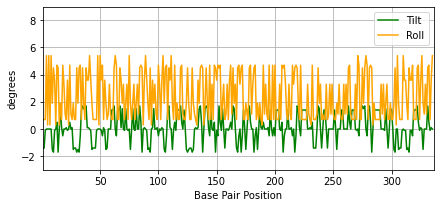

<Figure size 432x288 with 0 Axes>

In [11]:
# Task 2
# Plot all non-zero tilt and roll values as a function of base-pair position for the zech336_olson1998 parameters
# Make the tilt line green and the roll line orange

fig = plt.figure(figsize=(7,3))

plt.plot(seqdf[1:].tilt, c='green', label="Tilt")
plt.plot(seqdf[1:].roll, c='orange', label="Roll")

plt.xlim(1, len(seqdf))
plt.ylim(-3,9)

plt.xlabel("Base Pair Position")
plt.ylabel("degrees")

plt.legend()
plt.grid()

plt.show()
plt.clf()


In [12]:
# -!- make sure to delete any variables stored in the above code block here

del SEQ, seqdf

# --- Delete example variables

del N_seq, seq, stds, maindf


# -!- You may delete the "nb06_random-n125_olson1998.par" file from your directory


## Data Usage and Figure Generation

Previously we have worked with the all-atom .pdb files and the parametric .par files

In order to make base pair and base-pair steps, we need a set of reference frame data.

A refframe frame has 5 lines for every base-pair
 <li><b>line 1:   the nucleotide base-pair position and sequence</b></li>
 <li><b>line 2:   the base-pair origin in (x, y, z)</b></li>
 <li><b>line 3-5: the three unit vectors that describe the orientation of the reference frame</b></li>

This is an intermediate task because you first need to go through the file and store only the origin values into a dataframe with x, y, and z column labels


In [13]:
# Import modules (if not already loaded)


In [14]:
# Load and organize your data

infile = open("datafiles/test_dnarefframe.dat","r")
data   = infile.readlines()
infile.close()

# Extract the length of the sequence
# --- it is located in the top line, first string of that line
# --- we can use the .split(' ') function to turn that line into a space-separated list
N_seq = int( data[0].split(' ')[0] )

# Remove the header (for reference files it's just the first line) and new line characters
data   = [i.rstrip('\n') for i in data][1:]

data[0:25]

['... 1 C-G ...',
 '0.000000        0.000000        0.000000',
 '1.000000        0.000000        0.000000',
 '0.000000        1.000000        0.000000',
 '0.000000        0.000000        1.000000',
 '... 2 T-A ...',
 '-0.020027       -0.234622       3.358244',
 '0.839534        0.533871        -0.100819',
 '-0.532524       0.845367        0.042109',
 '0.107710        0.018337        0.994013',
 '... 3 G-C ...',
 '0.570304        0.121357        6.573844',
 '0.440799        0.881882        -0.167273',
 '-0.871257       0.465185        0.156566',
 '0.215886        0.076724        0.973400',
 '... 4 T-A ...',
 '-0.549297       -0.388096       10.346757',
 '-0.277814       0.960631        0.002566',
 '-0.945613       -0.273939       0.175424',
 '0.169221        0.046309        0.984490',
 '... 5 C-G ...',
 '-0.968479       0.297989        13.671970',
 '-0.726780       0.663771        0.176634',
 '-0.654638       -0.747231       0.114430',
 '0.207942        -0.032466       0.977602']

In [15]:
# The origin data is stored in a sequence of lines: For every block of 5 lines it's the 2nd line
# Thus, determine the INDEX pattern:
# line 1, 6, 11, 16, 21, 26, ... 
# line [0]*5 + 1 = 1, [1]*5 + 1 = 6, [2]*5 + 1 = 11
# so we want every 5*i + 1 line

origin_data = []

for i in range(0, N_seq):
    
    origin_data.append( data[5*i+1] )

# Finally, split each line based on the whitespace
origin_data = [i.split() for i in origin_data]

# View the top ten lines using index slicing
origin_data[0:10]

[['0.000000', '0.000000', '0.000000'],
 ['-0.020027', '-0.234622', '3.358244'],
 ['0.570304', '0.121357', '6.573844'],
 ['-0.549297', '-0.388096', '10.346757'],
 ['-0.968479', '0.297989', '13.671970'],
 ['0.596279', '-1.559716', '16.730356'],
 ['1.103430', '-3.610222', '20.036104'],
 ['3.223207', '-3.676751', '22.646583'],
 ['4.604122', '-3.949458', '25.828536'],
 ['6.146161', '-5.315528', '28.399514']]

In [16]:
# With this list of origin data, we can convert this to a easier to use DataFrame

origin_df = pd.DataFrame(data=origin_data, 
                         columns=['x','y','z'])

# We can us an .apply() method to make sure all data in this dataframe is numeric and not objects
origin_df = origin_df.apply(pd.to_numeric)

# We no longer need to list data
del origin_data

origin_df.head(10)

,x,y,z
0,0.000000,0.000000,0.000000
1,-0.020027,-0.234622,3.358244
2,0.570304,0.121357,6.573844
3,-0.549297,-0.388096,10.346757
4,-0.968479,0.297989,13.671970
5,0.596279,-1.559716,16.730356
6,1.103430,-3.610222,20.036104
7,3.223207,-3.676751,22.646583
8,4.604122,-3.949458,25.828536
9,6.146161,-5.315528,28.399514


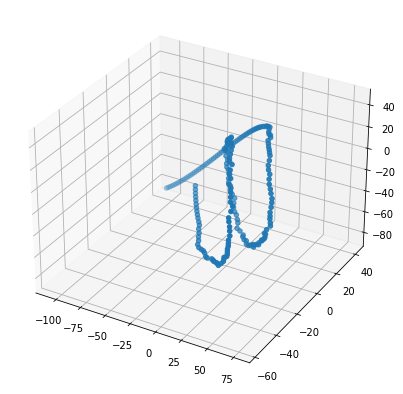

<Figure size 432x288 with 0 Axes>

In [17]:
# Create a 3-D scatter plot of this dataframe

fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(projection='3d')

ax.scatter(origin_df.x, origin_df.y, origin_df.z)

plt.show()
plt.clf()


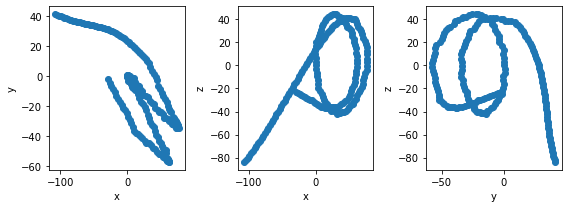

<Figure size 432x288 with 0 Axes>

In [18]:
# The 3D plot doesn't seem as helpful. Let's instead look at the 2D projections
# Make a 1x3 set of subplots to get a better look at these scatterplots

fig, axes = plt.subplots(1, 3, figsize=(8,3))

axes[0].scatter(origin_df.x, origin_df.y)
axes[0].set(xlabel="x", ylabel="y")

axes[1].scatter(origin_df.x, origin_df.z)
axes[1].set(xlabel="x", ylabel="z")

axes[2].scatter(origin_df.y, origin_df.z)
axes[2].set(xlabel="y", ylabel="z")

plt.tight_layout()
plt.show()
plt.clf()

# The images along with the 3D plot show a string that either comes out or goes into a supercoiled region, 
# similar to the '1KX5' model we used in a previous assignment

Having these 3D positions allows one to calculate, visualize, and understand relationships.

One such example would be to see how far each base-pair origin is from the other points. For a chain of 200 base pairs, we would need to determine the distance of every base relative to any other one. 

Recall that the distance formula is:
$$\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}$$

This means applying that formula 40,000 times.

We can use a function in the `scipy` package, spatial.distance, that would make it easier to calculate this.

In [19]:
from scipy.spatial import distance 

# In this is a function: pdist()

# Look up information on pdist() here: https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

# Calculate the pdist of the reference frame origins and then create a heatmap plot
distances = distance.pdist(origin_df)

print(distances)

[ 3.36648947  6.59965144 10.36859326 ...  3.43614256  6.69481774
  3.31430394]


In [20]:
distances.shape

(19900,)

In [21]:
# The 'distances' container we made is 19900 entries long. But we wanted something that was 200x200.
# There's another function, .squareform() that does just that

distances = distance.squareform(distances)

print(distances) 

[[ 0.          3.36648947  6.59965144 ...  9.79199772  6.55716657
   3.33623814]
 [ 3.36648947  0.          3.2886616  ... 13.07952876  9.87597161
   6.64984397]
 [ 6.59965144  3.2886616   0.         ... 16.19377431 12.98863558
   9.77774025]
 ...
 [ 9.79199772 13.07952876 16.19377431 ...  0.          3.43614256
   6.69481774]
 [ 6.55716657  9.87597161 12.98863558 ...  3.43614256  0.
   3.31430394]
 [ 3.33623814  6.64984397  9.77774025 ...  6.69481774  3.31430394
   0.        ]]


In [22]:
distances.shape

(200, 200)

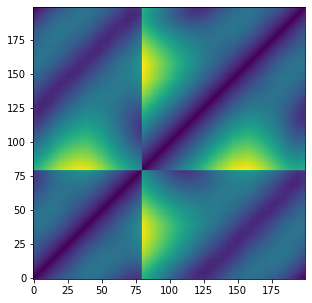

<Figure size 432x288 with 0 Axes>

In [23]:
# Once the data is in a square form, we can use plt.imshow() to make a 2D heatmap

fig = plt.figure(figsize=(5,5))

plt.imshow(distances, 
           # We can move the origin point from the default "upper" to "lower"
           origin="lower"
          )

plt.show()
plt.clf()


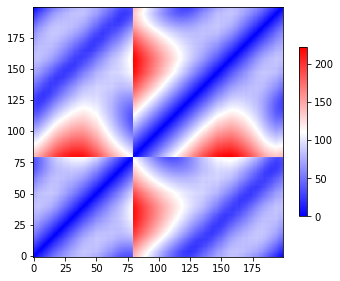

<Figure size 432x288 with 0 Axes>

In [24]:
# As with any figure, we can customize the colors. However for imshow(), we will need colormaps
# Check this out: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# We should use a diverging colormap so that white regions are closest to the mean

fig = plt.figure(figsize=(5,5))

plt.imshow(distances, 
           origin="lower", 
           # Use a blue-white-red cmap such that red is upper limit and blue lower limit
           cmap='bwr'
          )
# We will need to see what the colors mean, so we need a colorbar
plt.colorbar(shrink=0.50)

plt.tight_layout()
plt.show()
plt.clf()

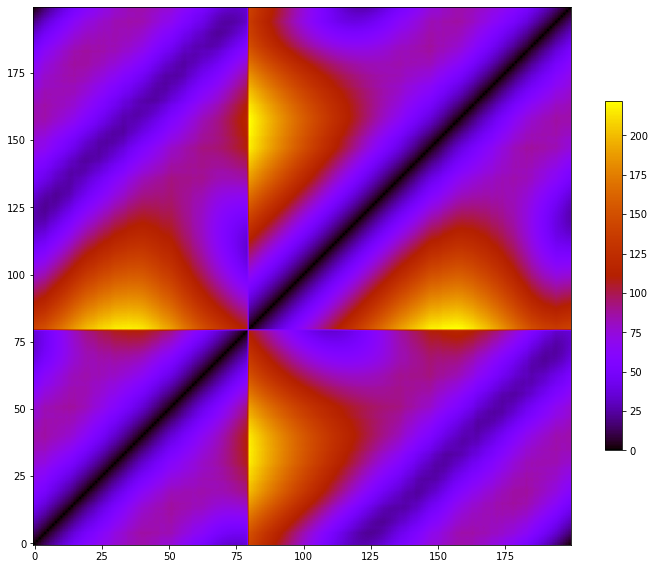

<Figure size 432x288 with 0 Axes>

In [28]:
# Lets try one last plot. We will use the 'gnuplot' colormap 
# but this time we will normalize the data 

fig = plt.figure(figsize=(10,10))

plt.imshow(distances, 
           origin="lower", 
           #norm="linear",
           cmap="gnuplot"
          )
plt.colorbar(shrink=0.50)

plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
del origin_df

## Distribution, statistics, and plotting with `seaborn`

Molecular model data offers great details, but if one were to make over 10,000 models, there needs to be ways to visualize large swaths of data.

Seaborn organizes its modules as either:

| __relplot__ | __displot__ | __catplot__ |
|:-------------:|:-------------:|:-------------:|
| _relational_ | _distributions_ | _categorical_ |
| scatterplot | histplot | stripplot |
| lineplot | kdeplot | swarmplot |
| | ecdfplot | boxplot |
| | rugplot | violinplot |
| | | pointplot |
| | | barplot |


A common use of Seaborn is to make __distribution__ plots. Let's look at the distribution of some results data


In [ ]:
import seaborn as sns


In [ ]:
df = pd.read_csv("datafiles/test_resultsdata", skiprows=1)
df

In [ ]:
# There are 24576 x 18 data entries in this file. We may want to plot everything, or want to work with a select set of data.
# Pandas has a method for selecting data using logic operators 

# For example, if I only want to see data where the "insert_label" is "h" and "opt_type" is "dim2022", I can select those in square brackets

df[ (df.insert_label=="h")
    &(df.opt_type=="dim2022") ]

# This "shrinks" the dataframe to 4096 x 18 and does not delete any of the data

In [ ]:
# Task: How many entries use both an 'AAAAAA' insert_seq and nmer_seq?

df[ (df.insert_seq=="AAAAAA")
    &(df.nmer_seq=="AAAAAA") ]

In [ ]:
# Task: How many entries with the "hnat" insert_label has a kinking angle at the 5-prime end (labeled phi_kink5) greater than 1.95?

df[ (df.insert_label=="hnat")
    &(df.phi_kink5 > 1.950) ]

In [ ]:
# We can make copies of DataFrames from these selections as a way to make analysis easier.
# Here we will make a plotting dataframe called plotdf that is a copy of the original
# selecting only the "tet2022" opt_type data
# Once it has been copied we will reset in the index numbering, making sure to say drop=True so we do not make a new column with the old index values
plotdf = df.copy()
plotdf = plotdf[ (plotdf.opt_type=="tet2022") ]
plotdf = plotdf.reset_index(drop=True)
plotdf.head()

In [ ]:
# This can also be written in a single line:
plotdf2 = df[ (df.opt_type=="dim2022") ].copy().reset_index(drop=True)
plotdf2.head()

In [ ]:
plotdf == plotdf2

In [ ]:
del plotdf2

Using these selection methods are great prior to plotting.

However, packages like `seaborn` allow selecting from within their plot functions.

Take for instance a distribution plot (`sns.displot()`) of only 'e_opt' data in the plotdf dataframe

In [ ]:
fig = plt.figure(figsize=(5,3))

sns.displot(data = plotdf,
            x = "e_opt")

plt.show()
plt.clf()


In [ ]:
# The above plot is for all data in the dataframe. But we know from earlier that there are different types of data, such as "opt_type" and "insert_types"
# We can select within the .displot() using "hue": we can make multiple distributions of different colors seperated by "insert_label"

fig = plt.figure(figsize=(5,3))

sns.displot(plotdf, x='e_opt', 
            hue="insert_label")

plt.show()
plt.clf()


In [ ]:
# We can separate these even more by using the 'col' keyword which makes columns of plots based on yet another selection

# This time we will go back to the original dataframe, df, and make distribution plots with columns based on "opt_type"

fig = plt.figure(figsize=(6,3))

sns.displot(df, 
            x='e_opt', 
            hue="insert_label", 
            col="opt_type")

plt.show()
plt.clf()

In [ ]:
# Well that's interesting. In use of whatever "tet2022" means, we have a wider swath of "e_opt" values than with the "dim2022" opt_type.
# Let's go deeper.

# Let's make a scatter plot of two columns-'e_optroll' and 'e_opttwist'- of a dataframe where we keep only 'h' insert_label data


In [ ]:
newdf = df[ (df.insert_label=="h") ].reset_index(drop=True)

fig = plt.figure(figsize=(3,3))

sns.scatterplot(newdf, 
                x='e_optroll',
                y='e_opttwist',
                hue="opt_type",
               alpha=0.25, edgecolor='black')

plt.show()
plt.clf()
del newdf

In [ ]:
# A great tool within seaborn is a .jointplot(), which can combine distributions with scatters

newdf = df[ (df.insert_label=="h") ].reset_index(drop=True)

fig = plt.figure(figsize=(3,3))

sns.jointplot(newdf, 
              x='e_optroll',
              y='e_opttwist',
              hue="opt_type",
              alpha=0.25, edgecolor='black')

plt.show()
plt.clf()
del newdf

In [ ]:
# Task:
# Make a df based on the "tet2022" opt_type and keep data where the e_opt values are less than the median e_opt.
# Plot 'e_optroll' and 'e_opttwist' and split the hue by insert_seq

newdf = df[ (df.opt_type=="tet2022")&(df.e_opt < df.e_opt.median()) ].reset_index(drop=True)

fig = plt.figure(figsize=(3,3))

sns.jointplot(newdf, 
              x='e_optroll',
              y='e_opttwist',
              hue="insert_seq",
              alpha=0.25, edgecolor='black')

plt.show()
plt.clf()
del newdf

In [ ]:
# I was to see all of the parametric energy relationships with the "tet2022" data, hence the pairplot function

fig = plt.figure()

newdf = df[ (df.opt_type=="tet2022") ].reset_index(drop=True)

sns.pairplot(newdf,
             vars=["e_opt"+par for par in ['tilt','roll','twist','shift','slide','rise']],
             hue="insert_label")

del newdf
plt.savefig("test_results_tet2022_pairplot.png", dpi=300)

plt.show()
plt.clf()

# This will produce a large 6X6 plot where the diagonals are the distributions of that data and off-diagonals are scatterplots between two parameters
# example: Row #3 y-axis is "e_opttwist", so in index [2,2] you will see the distribution of e_opttwist data. 
# Everything else in the row are scatterplots based on the x-axis labels

In [ ]:
# Dr. Robert Young, University of Maryland
# In collaboration with Matthew Osborne, Erdos Institute
# UMD FIRE Genome Computing